In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%matplotlib inline

In [78]:
LENGTH = 1000  # 每一个样本由1000个

def sample_data(size, length=100):
    """
    生成值得均值和方差的数据
    :param size:
    :param length:
    :return:
    """
    data = []
    for _ in range(size):
        data.append(sorted(np.random.normal(4, 1.5, length)))
    return np.array(data)


def random_data(size, length=100):
    """
    随机生成数据
    :param size:
    :param length:
    :return:
    """
    data = []
    for _ in range(size):
        x = np.random.random(length) 
        data.append(x)
    return np.array(data)


def preprocess_data(x):
    """
    计算每一组数据平均值和方差
    :param x:
    :return:
    """
    return [[np.mean(data), np.std(data)] for data in x]

In [79]:
x = tf.placeholder(tf.float32, shape=[None, 2], name="feature")  # [mean，std] -》 D
y = tf.placeholder(tf.float32, shape=[None, 1], name="label")
in_size = LENGTH
out_size = LENGTH

###################################### G  网络结构
# 第一层
z = tf.placeholder(tf.float32, shape=[None, LENGTH], name="noise")  # 随机值噪音
Weights = tf.Variable(tf.random_normal([in_size, 32]))
biases = tf.Variable(tf.zeros([1, 32]) + 0.1)
G_output = tf.matmul(z, Weights) + biases
G_output = tf.nn.relu(G_output)
# 第二层
Weights2 = tf.Variable(tf.random_normal([32, 32]))
biases2 = tf.Variable(tf.zeros([1, 32]) + 0.1)
G_output2 = tf.matmul(G_output, Weights2) + biases2
G_output2 = tf.nn.sigmoid(G_output2)
# 第三层
Weights3 = tf.Variable(tf.random_normal([32, out_size]))
biases3 = tf.Variable(tf.zeros([1, out_size]) + 0.1)
G_output3 = tf.matmul(G_output2, Weights3) + biases3

G_PARAMS = [Weights, biases, Weights2, biases2, Weights3, biases3]  # G的参数

###################################### D 网络结构(预训练的D)
# 第一层

dWeights = tf.Variable(tf.random_normal([2, 32]), name="D_W")
dbiases = tf.Variable(tf.zeros([1, 32]) + 0.1, name="D_b")
D_output = tf.matmul(x, dWeights) + dbiases
D_output = tf.nn.relu(D_output)
# 第二层
dWeights2 = tf.Variable(tf.random_normal([32, 32]), name="D_W2")
dbiases2 = tf.Variable(tf.zeros([1, 32]) + 0.1, name="D_b2")
D_output2 = tf.matmul(D_output, dWeights2) + dbiases2
D_output2 = tf.nn.sigmoid(D_output2)

# 第三层
dWeights3 = tf.Variable(tf.random_normal([32, 1]), name="D_W3")
dbiases3 = tf.Variable(tf.zeros([1, 1]) + 0.1, name="D_b3")
D_output3_ = tf.matmul(D_output2, dWeights3) + dbiases3
D_output3 = tf.nn.sigmoid(D_output3_)

D_PARAMS = [dWeights, dbiases,
            dWeights2, dbiases2,
            dWeights3, dbiases3]

##################################### GAN的结构

# 先求出G_output3的各行平均值和方差
MEAN = tf.reduce_mean(G_output3, 1)  # 行向量
MEAN_T = tf.transpose(tf.expand_dims(MEAN, 0))  # 转置
STD = tf.sqrt(tf.reduce_mean(tf.square(G_output3 - MEAN_T), 1))
DATA = tf.concat(1, [MEAN_T,
                     tf.transpose(tf.expand_dims(STD, 0))])

# GAN中的D
GAN_Weights = tf.Variable(tf.random_normal([2, 32]), name="GAN_W")
GAN_biases = tf.Variable(tf.zeros([1, 32]) + 0.1, name="GAN_b")
GAN_output = tf.matmul(DATA, GAN_Weights) + GAN_biases
GAN_output = tf.nn.relu(GAN_output)
# 第二层
GAN_Weights2 = tf.Variable(tf.random_normal([32, 32]), name="GAN_W2")
GAN_biases2 = tf.Variable(tf.zeros([1, 32]) + 0.1, name="GAN_b2")
GAN_output2 = tf.matmul(GAN_output, GAN_Weights2) + GAN_biases2
GAN_output2 = tf.nn.sigmoid(GAN_output2)

# 第三层
GAN_Weights3 = tf.Variable(tf.random_normal([32, 1]), name="GAN_W3")
GAN_biases3 = tf.Variable(tf.zeros([1, 1]) + 0.1, name="GAN_b3")
GAN_output3_ = tf.matmul(GAN_output2, GAN_Weights3) + GAN_biases3
GAN_output3 = tf.nn.sigmoid(GAN_output3_)

GAN_D_PARAMS = [GAN_Weights, GAN_biases,
                GAN_Weights2, GAN_biases2,
                GAN_Weights3, GAN_biases3]

In [80]:
##################################### 定义损失函数
d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(D_output3_, y))  # 二分类交叉熵
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(GAN_output3_, y))  # GAN二分类交叉熵

In [81]:
#################################### 定义优化器
d_optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(
    d_loss,
    global_step=tf.Variable(0),
    var_list=D_PARAMS
)

g_optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(
    g_loss,
    global_step=tf.Variable(0),
    var_list=G_PARAMS
)

In [82]:
d_loss_history = []
g_loss_history = []
epoch = 200
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # GAN博弈开始
    print('train GAN....')
    for step in range(epoch):
        # 先进行GAN中的D的训练，即对生成样本的判断
        for _ in range(100):
            # 使用G生成一批样本:
            real = sample_data(100,length=LENGTH)
            noise = random_data(100,length=LENGTH)
            generate = sess.run(G_output3, feed_dict={
                z: noise
            })  # 生成样本
            X = list(real) + list(generate)  
            X = preprocess_data(X)
            Y = [[1] for _ in range(len(real))] + [[0] for _ in range(len(generate))]
            d_loss_value, _ = sess.run([d_loss, d_optimizer], feed_dict={
                x: X,
                y: Y
            })  # 训练判别网络
            d_loss_history.append(d_loss_value)
        # 将参数移动过去GAN中的判别网络
        dp_value = sess.run(D_PARAMS)
        for i, v in enumerate(GAN_D_PARAMS):
            sess.run(v.assign(dp_value[i]))

        for _ in range(100):
            noise = random_data(100,length=LENGTH)
            g_loss_value, _ = sess.run([g_loss, g_optimizer], feed_dict={
                z: noise,
                y: [[1] for _ in range(len(noise))]  # 混肴为目标,不需要加入x，我们只是借助G，并不需要训练G
            })  # 调整G，让GAN的误差减少
            g_loss_history.append(g_loss_value)
        if step % 20 == 0 or step+1 == epoch:
            noise = random_data(1,length=LENGTH)
            generate = sess.run(G_output3, feed_dict={
                z: noise
            })
            print("[%4d] GAN-d-loss: %.12f  GAN-g-loss: %.12f   generate-mean: %.4f   generate-std: %.4f" % (step,
                            d_loss_value, g_loss_value,generate.mean() ,generate.std() ))
            
            
    print("train finish...")

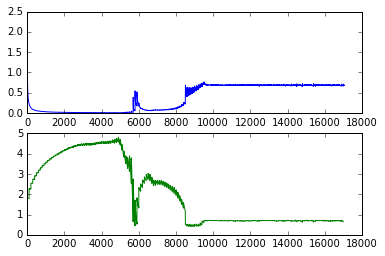

In [83]:
plt.subplot(211)
plt.plot(d_loss_history)
a = plt.subplot(212)
plt.plot(g_loss_history,c="g")

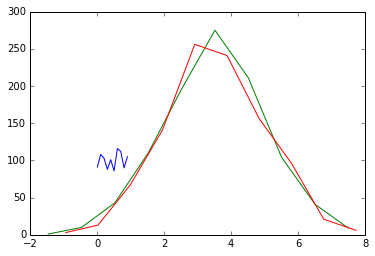

In [84]:
real = sample_data(1,length=LENGTH)
(data, bins) = np.histogram(real[0])
plt.plot(bins[:-1], data, c="g")


(data, bins) = np.histogram(noise[0])
plt.plot(bins[:-1], data, c="b")

# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     generate = sess.run(G_output3, feed_dict={
#             z: noise
#     })
(data, bins) = np.histogram(generate[0])
plt.plot(bins[:-1], data, c="r")

In [76]:
#x - x * z + log(1 + exp(-x))

pre = np.array([1,0])
real = np.array([0,1])

pre-pre*real + np.log(1+np.exp(-pre))

array([ 1.31326169,  0.69314718])